In [504]:
import torch
import numpy as np
import pandas as pd
import random 
from Evaluator import ModelEvaluator
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import itertools
import joblib as jb

## cargando los datos adversarios 2021

In [505]:
advData=pd.read_csv('datasets/Adversarial_data.csv')



In [506]:
advData.columns=['tcp_packets','dist_port_tcp','external_ips','vulume_bytes','udp_packets','source_app_packets','remote_app_packets','source_app_bytes','remote_app_bytes','dns_query_times']

Agregando los headers, a partir del conocimiento de los datos originales, teniendo en cuenta que el entrenamiento no es un proceso que realiza el atacante.

In [507]:
advData.describe()

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,dns_query_times
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,-4.923661,11.863727,-2.804275,7.070125,-8.336673,-0.574861,-2.568313,3.585495,-3.425601,-2.557615
std,24.800651,26.014930,21.525568,25.330662,27.736549,34.550386,27.172414,25.265104,27.837855,8.601629
min,-240.290698,-70.000000,-180.666667,-40.263012,-220.000000,-300.188889,-320.117647,-30.151903,-260.317734,-160.250000
25%,-10.116279,0.000000,-0.666667,-0.312383,-10.000000,-0.311111,-0.270588,-0.158578,-0.323299,-0.500000
50%,-0.290698,10.000000,-0.333333,-0.209178,0.000000,-0.200000,-0.247059,-0.127911,-0.252179,-0.250000
75%,0.488372,12.000000,0.666667,9.687617,0.000000,0.611111,0.611765,9.840956,1.300150,0.000000
max,28.116279,220.000000,52.000000,179.687617,20.000000,219.700000,57.635294,209.317157,152.172843,1.750000


In [508]:
advData['type']='malicious'

In [509]:
advData.head(3)

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,dns_query_times,type
0,-0.290698,0.0,-0.666667,-0.312383,0.0,-0.300000,-0.247059,-10.146441,-0.310605,0.00,malicious
1,-0.290698,10.0,-0.666667,-0.312383,0.0,-0.311111,-0.258824,-0.142638,9.683396,-20.25,malicious
2,9.709302,10.0,-20.666667,-10.312383,0.0,9.700000,-10.152941,-10.099873,-30.310257,0.00,malicious


## Cargando los datos adversarios 2018

In [510]:
dataAdversarial2018=pd.read_csv("datasets/Colcom2018AdversarialDataTrain.csv",header=0,sep=';')
print(dataAdversarial2018.head(3))
print(dataAdversarial2018.shape)

   tcp_packets  dist_port_tcp  external_ips  vulume_bytes  udp_packets  \
0     5.927622            0.0     -0.666667     39.884274          0.0   
1    22.138217            0.0     -0.666667     -0.312383          0.0   
2   104.151100            0.0     -0.666667    107.834553          0.0   

   source_app_packets  remote_app_packets   source_app_bytes  \
0          103.199390            0.700097         437.493903   
1           31.467176           -0.258824         625.873298   
2           35.351266           -0.270588         326.570370   

   remote_app_bytes  dns_query_times       type  
0          1.994524            -0.25  malicious  
1         24.786021            -0.25  malicious  
2         60.857192            -0.50  malicious  
(500, 11)


## Cargando los datos originales

In [511]:
data=pd.read_csv("datasets/Colcom2018CleanedScaled.csv",header=0,sep=';')
print(data.head(3))
print(data.shape)

   tcp_packets  dist_port_tcp  external_ips  vulume_bytes  udp_packets  \
0     0.127907            6.0      0.333333      0.036782          0.0   
1     1.069767            0.0      2.333333      1.786894          0.0   
2     1.988372            0.0      1.333333      1.843764          0.0   

   source_app_packets  remote_app_packets   source_app_bytes  \
0            0.100000            0.105882           0.041652   
1            1.088889            0.976471           0.897275   
2            1.944444            2.235294           6.465984   

   remote_app_bytes  dns_query_times    type  
0          0.029865              0.0  benign  
1          1.787684              2.0  benign  
2          1.831939              1.5  benign  
(7832, 11)


# Split for training and testing

## Primero los datos originales

In [512]:
golden_X_train, golden_X_test, golden_Y_train, golden_Y_test = train_test_split(data.iloc[:,0:10], data['type'], test_size=0.25, random_state=45)

## Segundo los datos del 2018

In [513]:
oldAdv_X_train, oldAdv_X_test, oldAdv_Y_train, oldAdv_Y_test = train_test_split(dataAdversarial2018.iloc[:,0:10], dataAdversarial2018['type'], test_size=0.25, random_state=45)
oldAdv_X_train.describe()

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,dns_query_times
count,375.000000,375.000000,375.000000,375.000000,375.0,375.000000,375.000000,375.000000,375.000000,375.000000
mean,66.178180,1.960000,-0.060444,30.283876,0.0,61.022679,44.999001,350.778233,31.253247,0.409333
std,38.829451,8.460098,0.642538,35.601006,0.0,37.578860,49.807078,205.699425,35.535859,3.569841
min,-0.124738,0.000000,-0.666667,-0.312383,0.0,-0.272351,-0.282353,0.972461,-0.324081,-0.750000
25%,31.452744,0.000000,-0.666667,-0.001116,0.0,25.860861,0.000000,182.830764,0.060165,-0.500000
50%,64.903574,0.000000,-0.333333,12.315596,0.0,60.284699,22.216226,338.752448,14.719542,-0.250000
75%,100.637787,0.000000,0.333333,59.233296,0.0,93.741430,88.186502,539.346371,64.195015,0.250000
max,133.092450,119.000000,4.333333,109.131622,0.0,127.434770,147.954122,710.062010,106.019676,64.500000


## Ahora los datos adversarios 2021

In [514]:
adv_X_train, adv_X_test, adv_Y_train, adv_Y_test = train_test_split(advData.iloc[:,0:10], advData['type'], test_size=0.25, random_state=50)
adv_X_train.describe()

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,dns_query_times
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,-5.826638,12.740642,-1.956328,5.248706,-8.235294,0.334492,-2.040075,4.131317,-2.975035,-2.743984
std,26.836895,27.880627,19.255371,20.129156,27.144499,27.182146,26.369000,27.487041,27.572327,9.460433
min,-240.290698,-31.000000,-170.666667,-40.263012,-210.000000,-270.300000,-320.117647,-30.151903,-260.317734,-160.250000
25%,-10.151163,0.000000,-0.666667,-0.312383,-10.000000,-0.311111,-0.270588,-0.158821,-0.318191,-0.500000
50%,-0.290698,10.000000,-0.333333,-0.232747,0.000000,-0.194444,-0.247059,-0.132846,-0.246267,-0.250000
75%,0.395349,12.000000,0.666667,9.687617,0.000000,0.575000,1.532353,9.839409,7.954866,0.000000
max,28.116279,220.000000,52.000000,169.687617,20.000000,209.700000,57.635294,209.317157,152.172843,1.750000


## Mezclando los datos para obtener un modelo mas robusto

In [515]:
golden_X_train.iloc[0:3,:]

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,dns_query_times
7750,-0.244186,0.0,-0.333333,-0.285957,0.0,-0.288889,-0.282353,-0.164688,-0.304345,-0.75
95,0.779070,0.0,2.000000,1.622712,0.0,0.811111,0.800000,0.694576,1.629187,2.00
3539,0.081395,0.0,0.333333,0.223998,0.0,0.066667,0.094118,0.006049,0.219228,0.25


In [516]:

golden_X_train=golden_X_train.reset_index(drop=True)
golden_Y_train=golden_Y_train.reset_index(drop=True)
golden_X_train.iloc[0:3,:]

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,dns_query_times
0,-0.244186,0.0,-0.333333,-0.285957,0.0,-0.288889,-0.282353,-0.164688,-0.304345,-0.75
1,0.779070,0.0,2.000000,1.622712,0.0,0.811111,0.800000,0.694576,1.629187,2.00
2,0.081395,0.0,0.333333,0.223998,0.0,0.066667,0.094118,0.006049,0.219228,0.25


In [517]:
oldAdv_X_train.describe()

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,dns_query_times
count,375.000000,375.000000,375.000000,375.000000,375.0,375.000000,375.000000,375.000000,375.000000,375.000000
mean,66.178180,1.960000,-0.060444,30.283876,0.0,61.022679,44.999001,350.778233,31.253247,0.409333
std,38.829451,8.460098,0.642538,35.601006,0.0,37.578860,49.807078,205.699425,35.535859,3.569841
min,-0.124738,0.000000,-0.666667,-0.312383,0.0,-0.272351,-0.282353,0.972461,-0.324081,-0.750000
25%,31.452744,0.000000,-0.666667,-0.001116,0.0,25.860861,0.000000,182.830764,0.060165,-0.500000
50%,64.903574,0.000000,-0.333333,12.315596,0.0,60.284699,22.216226,338.752448,14.719542,-0.250000
75%,100.637787,0.000000,0.333333,59.233296,0.0,93.741430,88.186502,539.346371,64.195015,0.250000
max,133.092450,119.000000,4.333333,109.131622,0.0,127.434770,147.954122,710.062010,106.019676,64.500000


## Agregando a los datos originales los datos del 2018

In [518]:

golden_X_train=golden_X_train.append(oldAdv_X_train, ignore_index = True)
golden_Y_train=golden_Y_train.append(oldAdv_Y_train, ignore_index = True)
golden_X_train.describe()

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,dns_query_times
count,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000
mean,5.190641,7.059369,0.227450,2.818189,0.030565,4.830082,4.391788,27.793857,2.856688,0.462554
std,19.200052,43.052894,0.952609,12.226265,0.663330,17.991058,17.910144,102.738714,12.302414,4.264307
min,-0.290698,0.000000,-0.666667,-0.312383,0.000000,-0.322222,-0.282353,-0.164688,-0.324081,-0.750000
25%,-0.220930,0.000000,-0.333333,-0.233104,0.000000,-0.244444,-0.200000,-0.121437,-0.237746,-0.500000
50%,0.046512,0.000000,0.000000,0.028926,0.000000,0.033333,0.023529,0.034491,0.026040,0.000000
75%,1.069767,0.000000,0.666667,0.892331,0.000000,1.022222,0.941176,2.237230,0.897211,0.500000
max,133.441860,1184.000000,10.666667,109.259173,30.000000,127.488889,147.976471,710.062010,106.407677,227.500000


## Agregando a los datos originales los datos adversarios del 2021

In [519]:
#corrige el espacio antes de remote_app_bytes de los datos anteriores.
golden_X_train.rename(columns={' source_app_bytes':'source_app_bytes'}, inplace=True)

In [520]:
golden_X_train=golden_X_train.append(adv_X_train, ignore_index = True)
golden_Y_train=golden_Y_train.append(adv_Y_train, ignore_index = True)
golden_X_train.describe()


,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,dns_query_times
count,6623.000000,6623.000000,6623.000000,6623.000000,6623.000000,6623.000000,6623.000000,6623.000000,6623.000000,6623.000000
mean,4.568497,7.380190,0.104132,2.955440,-0.436207,4.576217,4.028582,26.457637,2.527371,0.281481
std,19.871034,42.360016,4.689862,12.813149,6.749775,18.657248,18.547960,100.157351,13.690715,4.769329
min,-240.290698,-31.000000,-170.666667,-40.263012,-210.000000,-270.300000,-320.117647,-30.151903,-260.317734,-160.250000
25%,-0.220930,0.000000,-0.333333,-0.233104,0.000000,-0.255556,-0.211765,-0.127223,-0.245484,-0.500000
50%,0.023256,0.000000,0.000000,0.018480,0.000000,0.022222,0.011765,0.027775,0.010216,-0.250000
75%,1.046512,0.000000,0.666667,0.932015,0.000000,1.011111,0.941176,2.239678,0.914774,0.500000
max,133.441860,1184.000000,52.000000,169.687617,30.000000,209.700000,147.976471,710.062010,152.172843,227.500000


## Load discriminator

In [521]:
#plot confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [522]:

rdFnew=RandomForestClassifier(n_estimators=250, max_depth=50,random_state=45)
rdFnew.fit(golden_X_train,golden_Y_train)
pred=rdFnew.predict(golden_X_test)
cm=confusion_matrix(golden_Y_test, pred)

accuracy = accuracy_score(golden_Y_test,pred)
print(rdF)
print(accuracy)
print(classification_report(golden_Y_test,pred, labels=None))

print(cm)

RandomForestClassifier(max_depth=50, n_estimators=250, random_state=45)
0.9136874361593462
              precision    recall  f1-score   support

      benign       0.92      0.94      0.93      1190
   malicious       0.90      0.88      0.89       768

    accuracy                           0.91      1958
   macro avg       0.91      0.91      0.91      1958
weighted avg       0.91      0.91      0.91      1958

[[1116   74]
 [  95  673]]


## Secure learning

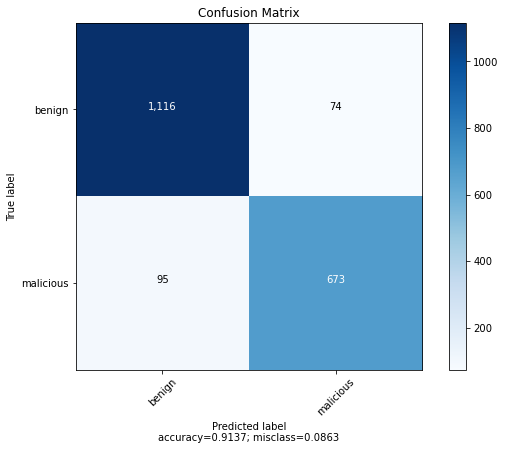

In [523]:
plot_confusion_matrix(cm, normalize = False, target_names = ['benign', 'malicious'], title = "Confusion Matrix")

In [524]:
pred=rdF.predict(oldAdv_X_test)
cm=confusion_matrix(oldAdv_Y_test, pred)
print(cm)
print(classification_report(oldAdv_Y_test,pred, labels=None))

[[ 0  0]
 [80 45]]
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00         0
   malicious       1.00      0.36      0.53       125

    accuracy                           0.36       125
   macro avg       0.50      0.18      0.26       125
weighted avg       1.00      0.36      0.53       125



C:\Users\janus\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\janus\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\janus\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [525]:
pred=rdF.predict(adv_X_test)
cm=confusion_matrix(adv_Y_test, pred)
print(cm)
print(classification_report(adv_Y_test,pred, labels=None))

[[  0   0]
 [  3 122]]
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00         0
   malicious       1.00      0.98      0.99       125

    accuracy                           0.98       125
   macro avg       0.50      0.49      0.49       125
weighted avg       1.00      0.98      0.99       125



C:\Users\janus\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\janus\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\janus\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


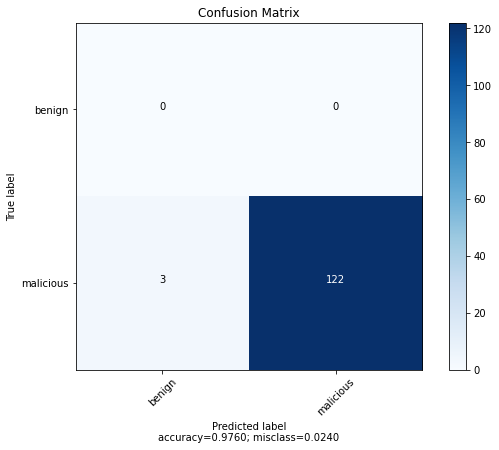

In [526]:
plot_confusion_matrix(cm, normalize = False, target_names = ['benign', 'malicious'], title = "Confusion Matrix")

In [527]:
model=jb.load('rfDefense2021.sav')
pred=model.predict(adv_X_test)
cm=confusion_matrix(adv_Y_test, pred)

accuracy = accuracy_score(adv_Y_test,pred)
print(rdF)
print(accuracy)
print(classification_report(adv_Y_test,pred, labels=None))

print(cm)

RandomForestClassifier(max_depth=50, n_estimators=250, random_state=45)
0.0
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00       0.0
   malicious       0.00      0.00      0.00     125.0

    accuracy                           0.00     125.0
   macro avg       0.00      0.00      0.00     125.0
weighted avg       0.00      0.00      0.00     125.0

[[  0   0]
 [125   0]]


C:\Users\janus\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\janus\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\janus\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\

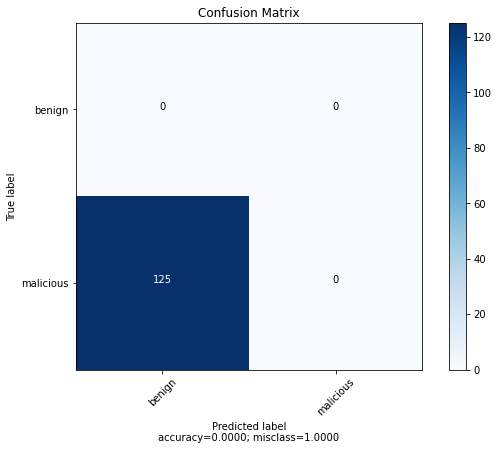

In [528]:
plot_confusion_matrix(cm, normalize = False, target_names = ['benign', 'malicious'], title = "Confusion Matrix")

In [529]:
Golden=pd.read_csv("./datasets/Colcom2018CleanedScaled.csv",header=0,sep=';')
Adv2018=pd.read_csv("./datasets/Colcom2018AdversarialDataTrain.csv",header=0,sep=';')
Adv2021=pd.read_csv("./datasets/Adversarial_data.csv")
colsTemp=['tcp_packets','dist_port_tcp','external_ips','vulume_bytes','udp_packets','source_app_packets','remote_app_packets',' source_app_bytes','remote_app_bytes','dns_query_times']
Adv2021.columns=colsTemp
Adv2021['type']='malicious'


In [530]:
finalData=Golden.append(Adv2018, ignore_index = True)
finalData=finalData.append(Adv2021, ignore_index = True)
finalData.describe()

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,dns_query_times
count,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000,8831.000000
mean,4.648776,7.177783,0.057676,3.067020,-0.441626,4.635387,3.869165,25.915814,2.508606,0.300476
std,19.884964,39.699975,5.239873,13.432326,6.895693,19.691788,18.179035,98.743865,13.779071,5.033060
min,-240.290698,-70.000000,-180.666667,-40.263012,-220.000000,-300.188889,-320.117647,-30.151903,-260.317734,-160.250000
25%,-0.220930,0.000000,-0.333333,-0.233104,0.000000,-0.255556,-0.211765,-0.126899,-0.245484,-0.500000
50%,0.034884,0.000000,0.000000,0.028301,0.000000,0.033333,0.011765,0.031133,0.018736,-0.250000
75%,1.058140,0.000000,0.666667,0.956923,0.000000,1.022222,0.941176,2.256165,0.916600,0.500000
max,133.441860,1184.000000,52.000000,179.687617,30.000000,219.700000,147.976471,715.616633,152.172843,227.500000


In [531]:
X_train,X_test, Y_train, Y_test = train_test_split(finalData.iloc[:,0:10], finalData['type'], test_size=8830, random_state=45)

In [532]:
X_test.shape

(8830, 10)

In [533]:
model=jb.load('rfDefense2021.sav')
pred=model.predict(X_test)
cm=confusion_matrix(Y_test, pred)

accuracy = accuracy_score(Y_test,pred)
print(rdF)
print(accuracy)
print(classification_report(Y_test,pred, labels=None))

print(cm)

RandomForestClassifier(max_depth=50, n_estimators=250, random_state=45)
0.8613816534541336
              precision    recall  f1-score   support

      benign       0.81      0.97      0.88      4691
   malicious       0.96      0.74      0.83      4139

    accuracy                           0.86      8830
   macro avg       0.88      0.85      0.86      8830
weighted avg       0.88      0.86      0.86      8830

[[4562  129]
 [1095 3044]]


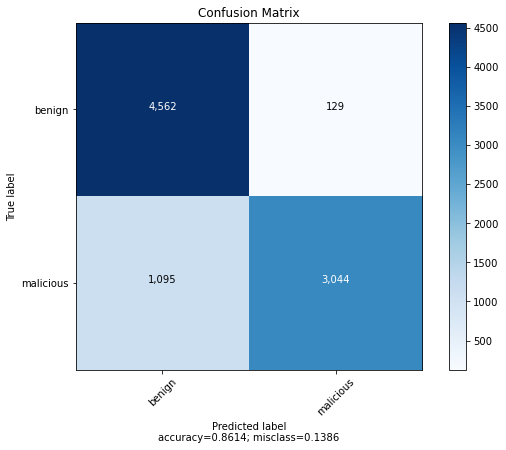

In [534]:
plot_confusion_matrix(cm, normalize = False, target_names = ['benign', 'malicious'], title = "Confusion Matrix")

In [535]:
pred=rdFnew.predict(X_test)
cm=confusion_matrix(Y_test, pred)

accuracy = accuracy_score(Y_test,pred)
print(rdF)
print(accuracy)
print(classification_report(Y_test,pred, labels=None))

print(cm)

RandomForestClassifier(max_depth=50, n_estimators=250, random_state=45)
0.9733861834654587
              precision    recall  f1-score   support

      benign       0.98      0.97      0.97      4691
   malicious       0.97      0.97      0.97      4139

    accuracy                           0.97      8830
   macro avg       0.97      0.97      0.97      8830
weighted avg       0.97      0.97      0.97      8830

[[4561  130]
 [ 105 4034]]


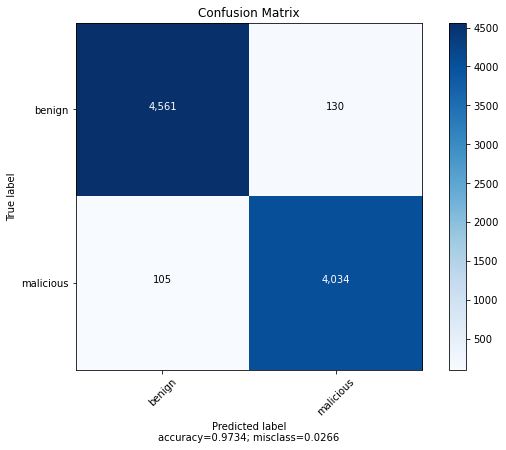

In [536]:
plot_confusion_matrix(cm, normalize = False, target_names = ['benign', 'malicious'], title = "Confusion Matrix")